# 💍 Ring Image Feature Extraction & Model Training

This notebook trains a CNN-based feature extraction system for ring image matching and similarity search.

**Features:**
- Uses VGG16 pre-trained on ImageNet for transfer learning
- Extracts 512-dimensional feature vectors from images
- Computes perceptual hashes for exact matching
- Builds a searchable database of all ring images

**Output Files:**
- `ring_model.h5` - Keras feature extraction model
- `ring_database.pkl` - Image features and metadata database

## 1. Import Required Libraries

In [8]:
import os
import numpy as np
import pickle
from PIL import Image
import hashlib
from tqdm import tqdm  # Use standard tqdm instead of notebook version
import matplotlib.pyplot as plt

# TensorFlow/Keras imports
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.models import Model

# Check for GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ GPU available: {gpus}")
else:
    print("⚠️ No GPU found, using CPU (training will be slower)")

print(f"TensorFlow version: {tf.__version__}")

⚠️ No GPU found, using CPU (training will be slower)
TensorFlow version: 2.20.0


## 2. Configuration

In [9]:
# Configuration
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

# Dataset directories (relative to notebook location)
DATASET_DIR = 'ring'           # Original images folder
AUGMENTED_DIR = 'ring_augmented'  # Augmented images folder

# Output files
MODEL_PATH = 'ring_model.h5'
DATABASE_PATH = 'ring_database.pkl'

print("📁 Configuration:")
print(f"   Image size: {IMAGE_SIZE}")
print(f"   Dataset directory: {DATASET_DIR}")
print(f"   Augmented directory: {AUGMENTED_DIR}")
print(f"   Model output: {MODEL_PATH}")
print(f"   Database output: {DATABASE_PATH}")

📁 Configuration:
   Image size: (224, 224)
   Dataset directory: ring
   Augmented directory: ring_augmented
   Model output: ring_model.h5
   Database output: ring_database.pkl


## 3. Load and Explore Dataset

In [10]:
# Collect all image paths
def get_image_paths(directory):
    """Get all image file paths from a directory."""
    if not os.path.exists(directory):
        return []
    
    valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.gif')
    images = []
    for filename in os.listdir(directory):
        if filename.lower().endswith(valid_extensions):
            images.append(os.path.join(directory, filename))
    return sorted(images)

# Get original and augmented images
original_images = get_image_paths(DATASET_DIR)
augmented_images = get_image_paths(AUGMENTED_DIR)

# Identify original images in augmented folder
original_in_augmented = [p for p in augmented_images if '_original' in p]

print("📊 Dataset Summary:")
print(f"   Original images in '{DATASET_DIR}': {len(original_images)}")
print(f"   Augmented images in '{AUGMENTED_DIR}': {len(augmented_images)}")
print(f"   - Originals: {len(original_in_augmented)}")
print(f"   - Augmented: {len(augmented_images) - len(original_in_augmented)}")
print(f"\n   Total images: {len(original_images) + len(augmented_images)}")

📊 Dataset Summary:
   Original images in 'ring': 177
   Augmented images in 'ring_augmented': 1947
   - Originals: 177
   - Augmented: 1770

   Total images: 2124


C:\Users\AsadMunir\AppData\Local\Temp\ipykernel_21152\2947922274.py:17: UserWarning: Glyph 128247 (\N{CAMERA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


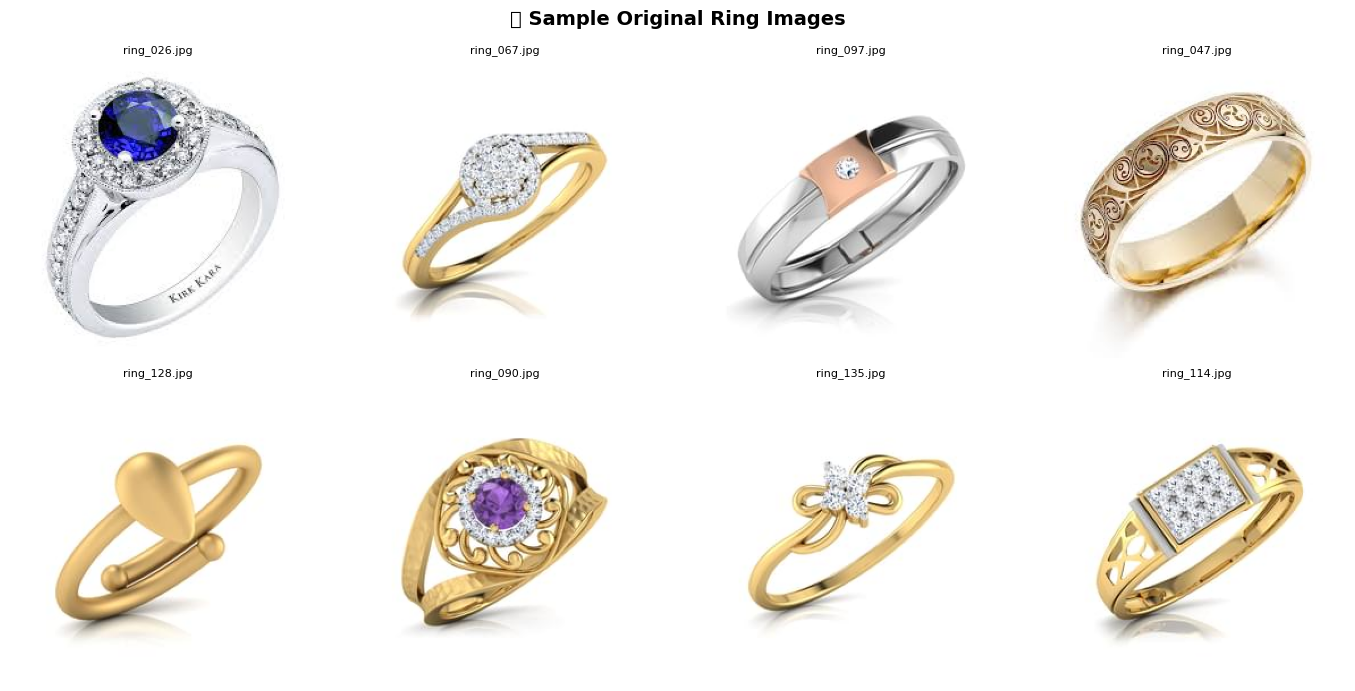

In [11]:
# Visualize sample images from the dataset
def display_sample_images(image_paths, title, n=8):
    """Display a grid of sample images."""
    n = min(n, len(image_paths))
    fig, axes = plt.subplots(2, 4, figsize=(14, 7))
    fig.suptitle(title, fontsize=14, fontweight='bold')
    
    sample_indices = np.random.choice(len(image_paths), n, replace=False)
    
    for idx, ax in enumerate(axes.flat):
        if idx < n:
            img = Image.open(image_paths[sample_indices[idx]])
            ax.imshow(img)
            ax.set_title(os.path.basename(image_paths[sample_indices[idx]])[:20], fontsize=8)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Display samples from original images
if original_images:
    display_sample_images(original_images, "📷 Sample Original Ring Images")

## 4. Build Feature Extraction Model (VGG16)

In [12]:
def create_feature_extractor():
    """
    Create a feature extraction model using VGG16 pre-trained on ImageNet.
    We remove the top classification layers and use GlobalAveragePooling
    to get a fixed-size 512-dimensional feature vector.
    """
    print("🔧 Loading VGG16 base model (this may take a moment on first run)...")
    
    # Load VGG16 without the top classification layers
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # Add GlobalAveragePooling to convert feature maps to a vector
    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    # Create the feature extractor model
    feature_extractor = Model(inputs=base_model.input, outputs=x)
    
    print(f"✅ Feature extractor created!")
    print(f"   Input shape: {feature_extractor.input_shape}")
    print(f"   Output shape: {feature_extractor.output_shape}")
    print(f"   Total parameters: {feature_extractor.count_params():,}")
    
    return feature_extractor

# Create the model
feature_extractor = create_feature_extractor()

🔧 Loading VGG16 base model (this may take a moment on first run)...
✅ Feature extractor created!
   Input shape: (None, 224, 224, 3)
   Output shape: (None, 512)
   Total parameters: 14,714,688


## 5. Define Preprocessing Functions

In [13]:
def load_and_preprocess_image(img_path, target_size=IMAGE_SIZE):
    """
    Load an image and preprocess it for VGG16.
    """
    try:
        img = keras_image.load_img(img_path, target_size=target_size)
        img_array = keras_image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)
        return img_array
    except Exception as e:
        print(f"❌ Error loading image {img_path}: {e}")
        return None

def compute_image_hash(img_path):
    """
    Compute a perceptual hash of an image for exact matching.
    Uses average hash (aHash) algorithm - robust to small changes.
    """
    try:
        img = Image.open(img_path).convert('L')  # Convert to grayscale
        img = img.resize((16, 16), Image.Resampling.LANCZOS)
        pixels = np.array(img).flatten()
        avg = pixels.mean()
        hash_bits = ''.join(['1' if p > avg else '0' for p in pixels])
        return hash_bits
    except Exception as e:
        print(f"❌ Error computing hash for {img_path}: {e}")
        return None

def normalize_features(features):
    """
    L2 normalize feature vectors for cosine similarity computation.
    """
    norms = np.linalg.norm(features, axis=1, keepdims=True)
    norms = np.where(norms == 0, 1, norms)  # Avoid division by zero
    return features / norms

print("✅ Preprocessing functions defined!")

✅ Preprocessing functions defined!


## 6. Extract Features from All Images

This is the main training step - we'll extract deep features from every image in the dataset.
The progress bar will show real-time progress.

In [14]:
# Prepare database structure
database = {
    'image_paths': [],
    'features': [],
    'hashes': [],
    'original_paths': []  # Track which images are originals
}

# Combine all images
all_images = original_images + augmented_images
database['image_paths'] = all_images

# Track original images
database['original_paths'] = original_images.copy()
database['original_paths'].extend([p for p in augmented_images if '_original' in p])

print(f"🚀 Starting feature extraction for {len(all_images)} images...")
print(f"   This may take several minutes depending on your hardware.\n")

# Extract features with progress bar
features_list = []
hashes_list = []
failed_images = []

for img_path in tqdm(all_images, desc="🔍 Extracting features", unit="img"):
    # Load and preprocess image
    img = load_and_preprocess_image(img_path)
    
    if img is not None:
        # Extract features
        feature = feature_extractor.predict(img, verbose=0)[0]
        features_list.append(feature)
        
        # Compute hash
        img_hash = compute_image_hash(img_path)
        hashes_list.append(img_hash)
    else:
        # Use zero features and empty hash for failed images
        features_list.append(np.zeros(512))
        hashes_list.append(None)
        failed_images.append(img_path)

# Convert to numpy array
database['features'] = np.array(features_list)
database['hashes'] = hashes_list

print(f"\n✅ Feature extraction complete!")
print(f"   Processed: {len(all_images)} images")
print(f"   Failed: {len(failed_images)} images")
print(f"   Feature matrix shape: {database['features'].shape}")

🚀 Starting feature extraction for 2124 images...
   This may take several minutes depending on your hardware.



🔍 Extracting features: 100%|██████████| 2124/2124 [20:17<00:00,  1.74img/s]


✅ Feature extraction complete!
   Processed: 2124 images
   Failed: 0 images
   Feature matrix shape: (2124, 512)


## 7. Visualize Feature Space (t-SNE)

🎨 Running t-SNE visualization on 500 samples...


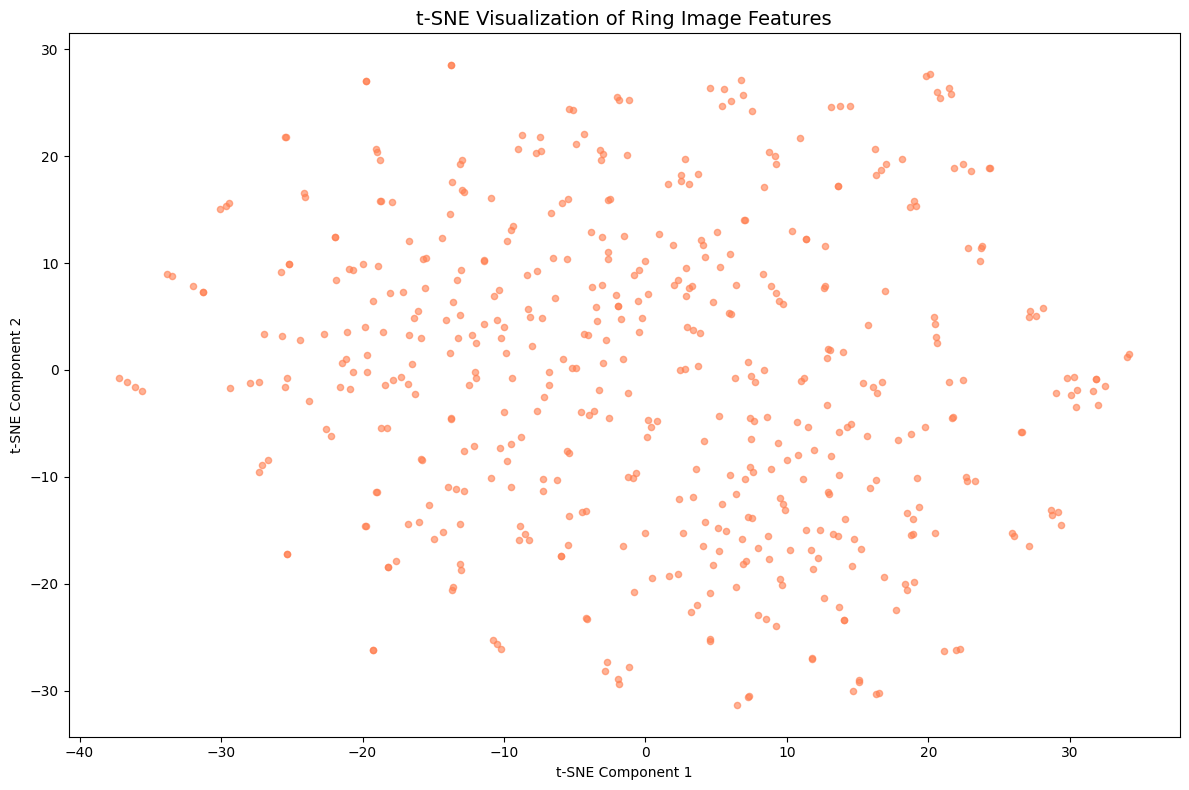

✅ Visualization complete! Similar rings should cluster together.


In [17]:
# Optional: Visualize feature space using t-SNE (for smaller datasets)
# This helps understand how well the model separates different rings

from sklearn.manifold import TSNE

# Use a sample if dataset is large
max_samples = min(500, len(database['features']))
sample_indices = np.random.choice(len(database['features']), max_samples, replace=False)
sample_features = database['features'][sample_indices]

print(f"🎨 Running t-SNE visualization on {max_samples} samples...")

# Run t-SNE (using max_iter for newer scikit-learn versions)
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
features_2d = tsne.fit_transform(sample_features)

# Plot
plt.figure(figsize=(12, 8))
plt.scatter(features_2d[:, 0], features_2d[:, 1], alpha=0.6, s=20, c='coral')
plt.title('t-SNE Visualization of Ring Image Features', fontsize=14)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.tight_layout()
plt.show()

print("✅ Visualization complete! Similar rings should cluster together.")

## 8. Test Similarity Search

C:\Users\AsadMunir\AppData\Local\Temp\ipykernel_21152\1150450448.py:41: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\AsadMunir\Downloads\Rings\mystuff\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


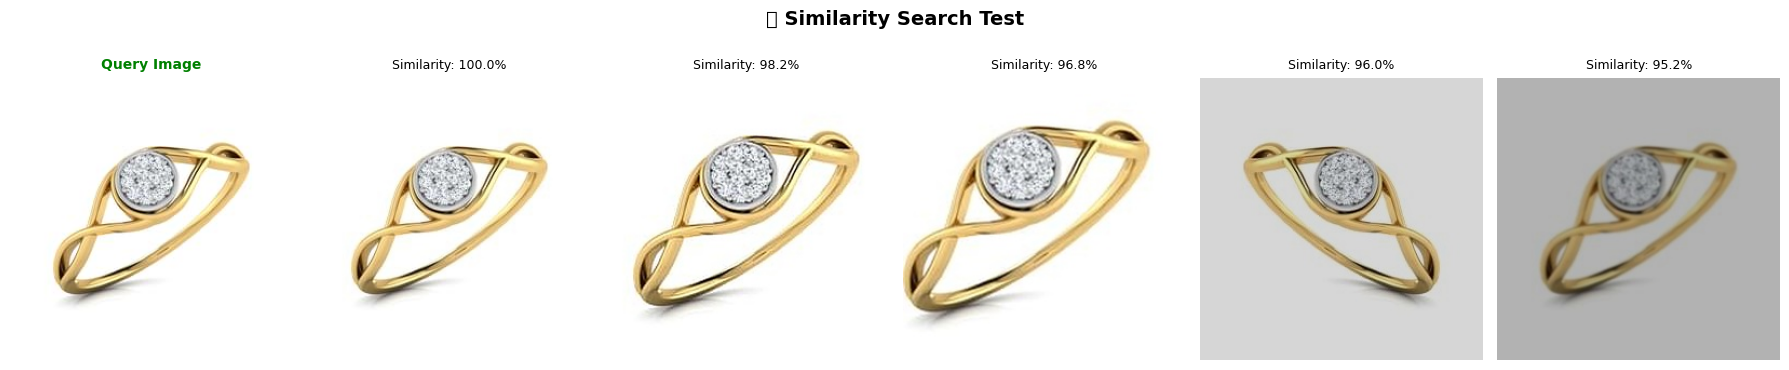

✅ Similarity search is working correctly!


In [18]:
# Test the similarity search with a random image
def find_similar_images(query_idx, features, image_paths, top_k=5):
    """Find the most similar images to a query image."""
    query_feature = features[query_idx]
    
    # Normalize for cosine similarity
    query_norm = query_feature / np.linalg.norm(query_feature)
    all_norms = features / np.linalg.norm(features, axis=1, keepdims=True)
    
    # Compute similarities
    similarities = np.dot(all_norms, query_norm)
    
    # Get top-k (excluding the query itself)
    sorted_indices = np.argsort(similarities)[::-1]
    top_indices = [i for i in sorted_indices if i != query_idx][:top_k]
    
    return top_indices, similarities[top_indices]

# Test with a random image
if len(original_images) > 0:
    test_idx = np.random.randint(0, len(original_images))
    similar_indices, similarities = find_similar_images(test_idx, database['features'], database['image_paths'])
    
    # Visualize
    fig, axes = plt.subplots(1, 6, figsize=(18, 4))
    
    # Query image
    query_img = Image.open(database['image_paths'][test_idx])
    axes[0].imshow(query_img)
    axes[0].set_title('Query Image', fontsize=10, fontweight='bold', color='green')
    axes[0].axis('off')
    
    # Similar images
    for i, (idx, sim) in enumerate(zip(similar_indices, similarities)):
        img = Image.open(database['image_paths'][idx])
        axes[i+1].imshow(img)
        axes[i+1].set_title(f'Similarity: {sim*100:.1f}%', fontsize=9)
        axes[i+1].axis('off')
    
    plt.suptitle('🔍 Similarity Search Test', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("✅ Similarity search is working correctly!")

## 9. Save Model and Database

In [19]:
# Normalize features for efficient similarity search
print("🔧 Normalizing features for similarity search...")
database['features_normalized'] = normalize_features(database['features'])

# Save the Keras model
print(f"\n💾 Saving model to {MODEL_PATH}...")
feature_extractor.save(MODEL_PATH)

# Save the database
print(f"💾 Saving database to {DATABASE_PATH}...")
with open(DATABASE_PATH, 'wb') as f:
    pickle.dump(database, f)

# Verify files were created
model_size = os.path.getsize(MODEL_PATH) / (1024 * 1024)  # MB
db_size = os.path.getsize(DATABASE_PATH) / (1024 * 1024)  # MB

print("\n" + "="*60)
print("✅ TRAINING COMPLETE!")
print("="*60)
print(f"\n📁 Output Files:")
print(f"   {MODEL_PATH} ({model_size:.1f} MB)")
print(f"   {DATABASE_PATH} ({db_size:.1f} MB)")
print(f"\n📊 Database Statistics:")
print(f"   Total images indexed: {len(database['image_paths'])}")
print(f"   Original images: {len(database['original_paths'])}")
print(f"   Feature vector dimension: {database['features'].shape[1]}")
print(f"\n🚀 Next Steps:")
print("   1. Run 'python app.py' to start the web server")
print("   2. Open http://localhost:5000 in your browser")
print("   3. Upload a ring image to search for matches!")
print("="*60)

🔧 Normalizing features for similarity search...

💾 Saving model to ring_model.h5...
💾 Saving database to ring_database.pkl...

✅ TRAINING COMPLETE!

📁 Output Files:
   ring_model.h5 (56.2 MB)
   ring_database.pkl (8.9 MB)

📊 Database Statistics:
   Total images indexed: 2124
   Original images: 354
   Feature vector dimension: 512

🚀 Next Steps:
   1. Run 'python app.py' to start the web server
   2. Open http://localhost:5000 in your browser
   3. Upload a ring image to search for matches!
